In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer, one_hot
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import nltk
import numpy as np
import operator
from pipe import *

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
vocab_size = 1000

from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=1000)

In [3]:
review = 200

In [4]:
word_index = imdb.get_word_index()

reverse_word_index = list( word_index.items() ) \
    | select( lambda i: (i[1],i[0]) ) \
    | as_dict

decoded_review = train_data[review] \
    | select( lambda i: reverse_word_index.get(i - 3, '?') ) \
    | as_list

print( ' '.join(decoded_review) )

? this is a bit long 2 hours 20 minutes but it had a a lot of the famous ? ? novel in it in other words a lot of ? to ? br br it was ? ? at times but had some ? dramatic moments too ? off by a ? ? at the end of the film that was ? to view ? this film is about ? years old the special effects ? on this film did a ? job br br paul ? and ? ? were ? ? actors in their day and they don't ? here both giving powerful performances the only problem is ? as all the ? are played by ? and some of them like ? ? just don't look real i'd like to see a re make of this movie with all ? actors not for ? ? but to simply make the story look and sound more ?


In [6]:
%%time
from keras.preprocessing.sequence import skipgrams

words = []
contexts = []
ys = []

for embedding in train_data:
    x,y = skipgrams( embedding, vocab_size )    
    word = [x[0] for x in x]
    context = [x[1] for x in x]
    
    words.extend(word)
    contexts.extend(context)
    ys.extend(y)
    
    if len(words) > 1000000:
        break

Wall time: 4.47 s


In [81]:
y

[0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,


In [8]:
%%time
ohe = OneHotEncoder(n_values=vocab_size)

W = ohe.fit_transform(np.array(words).reshape(-1, 1)).todense()
C = ohe.fit_transform(np.array(contexts).reshape(-1, 1)).todense()
Y = np.array(ys)

Wtrain, Wtest, Ctrain, Ctest, Ytrain, Ytest = train_test_split( W, C, Y, test_size=0.3, random_state=42)

print(Wtrain.shape, Ctrain.shape, Ytrain.shape)
print(Wtest.shape, Ctest.shape, Ytest.shape)

(705980, 1000) (705980, 1000) (705980,)
(302564, 1000) (302564, 1000) (302564,)
Wall time: 24.6 s


In [9]:
from keras.layers import Activation, Embedding, dot, Reshape, Input
from keras.models import Sequential, Model

input_targetword = Input(shape=(vocab_size,))
inputs_context = Input(shape=(vocab_size,))
target_word = Dense(30)(input_targetword)
context = Dense(30)(inputs_context)

drop_context = Dropout(0.4)(context)
drop_target = Dropout(0.4)(target_word)

ddot = dot([drop_target, drop_context], 1)
reshape = Reshape((1,), input_shape=(1, 1))(ddot)
net_output = Activation('sigmoid')(reshape)

model = Model(inputs=[input_targetword, inputs_context], outputs=[net_output])

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           30030       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           30030       input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [71]:
%%time
history = model.fit([Wtrain, Ctrain], Ytrain, batch_size=500,
                    epochs=50, verbose=1,
                    validation_data=([Wtest, Ctest], Ytest))

Train on 705980 samples, validate on 302564 samples
Epoch 1/50
705980/705980 [==============================] - 21s 30us/step - loss: 0.3990 - val_loss: 0.3941
Epoch 2/50
705980/705980 [==============================] - 21s 30us/step - loss: 0.3992 - val_loss: 0.3940
Epoch 3/50
705980/705980 [==============================] - 21s 30us/step - loss: 0.3987 - val_loss: 0.3940
Epoch 4/50
705980/705980 [==============================] - 21s 30us/step - loss: 0.3987 - val_loss: 0.3938
Epoch 5/50
705980/705980 [==============================] - 21s 30us/step - loss: 0.3987 - val_loss: 0.3939
Epoch 6/50
705980/705980 [==============================] - 21s 30us/step - loss: 0.3988 - val_loss: 0.3938
Epoch 7/50
705980/705980 [==============================] - 21s 30us/step - loss: 0.3986 - val_loss: 0.3938
Epoch 8/50
705980/705980 [==============================] - 21s 30us/step - loss: 0.3982 - val_loss: 0.3939
Epoch 9/50
705980/705980 [==============================] - 21s 30us/step - loss: 0.

In [62]:
from keras.utils import plot_model
plot_model(model, to_file='ns-sg-softmax.png')

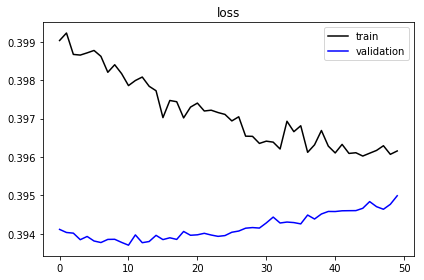

In [72]:

# plot loss function
plt.title("loss")
plt.plot(history.history["loss"], color="k", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [73]:
# evaluate model
score = model.evaluate( [Wtest, Ctest], Ytest, verbose=1)
print("Test score: {:.3f}".format(score))

# retrieve the weights from the first dense layer. This will convert
# the input vector from a one-hot sum of two words to a dense 300
# dimensional representation
W, b = model.layers[2].get_weights()

302564/302564 [==============================] - 9s 30us/step
Test score: 0.395


In [49]:
model.layers

In [74]:
len(word_index.keys())

88584

In [66]:
words=range(10,1000) | select( lambda i: reverse_word_index[i] ) | as_list

In [75]:
idx2emb = {}

Wt = W

for word in words:
    wid = word_index[word]
    vec_in = ohe.fit_transform(np.array(wid)).todense()
    vec_emb = np.dot(vec_in, Wt)
    idx2emb[wid] = vec_emb


In [76]:
for word in ["girl", "money", "american"]:
    wid = word_index[word]
    source_emb = idx2emb[wid]S
    distances = []
    for i in range(10, vocab_size):
        if i == wid:
            continue
        target_emb = idx2emb[i]
        distances.append(((wid, i),
                         cosine_distances(source_emb, target_emb)))
    sorted_distances = sorted(distances, key=operator.itemgetter(1))[0:10]
    predictions = [reverse_word_index[x[0][1]] for x in sorted_distances]
    print("{:s} => {:s}".format(word, ", ".join(predictions)))

girl => movies, go, entertainment, role, during, film, too, thought, remember, so
money => by, day, me, will, characters, i'm, there, this, an, good
american => from, were, order, who, really, all, they, any, are, those


In [77]:
WORDS = np.zeros( (990, 30) )

for i in range(10,990):
    WORDS[i] = idx2emb[i]

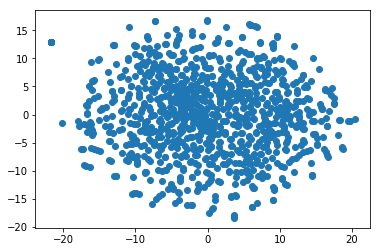

In [79]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(WORDS)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)